In [ ]:
!pip install bayesian-optimization

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

from bayes_opt import BayesianOptimization

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/preprocessed_v2/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/preprocessed_v2/Testing'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.15
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4687 images belonging to 4 classes.
Found 826 images belonging to 4 classes.
Found 1212 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.regularizers import l2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[reduce_lr, early_stopping]
)

model.save('VGG16_initial.keras')

Epoch 1/15
147/147 [==============================] - 1686s 11s/step - loss: 1.2987 - accuracy: 0.3983 - val_loss: 1.0492 - val_accuracy: 0.6465 - lr: 1.0000e-04
Epoch 2/15
147/147 [==============================] - 128s 870ms/step - loss: 0.9699 - accuracy: 0.5965 - val_loss: 0.9007 - val_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 3/15
147/147 [==============================] - 127s 864ms/step - loss: 0.8265 - accuracy: 0.6699 - val_loss: 0.8325 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 4/15
147/147 [==============================] - 127s 863ms/step - loss: 0.7495 - accuracy: 0.7135 - val_loss: 0.7944 - val_accuracy: 0.7082 - lr: 1.0000e-04
Epoch 5/15
147/147 [==============================] - 128s 866ms/step - loss: 0.6791 - accuracy: 0.7474 - val_loss: 0.7784 - val_accuracy: 0.6998 - lr: 1.0000e-04
Epoch 6/15
147/147 [==============================] - 129s 878ms/step - loss: 0.6373 - accuracy: 0.7574 - val_loss: 0.7229 - val_accuracy: 0.7094 - lr: 1.0000e-04
Epoch 7/15
147/147 [===

In [ ]:
def fine_tune_model(learning_rate, dropout_rate):
    for layer in model.layers:
        if isinstance(layer, Dropout):
            layer.rate = dropout_rate

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=3,
        callbacks=[reduce_lr, early_stopping],
        verbose=0
    )

    return max(history.history['val_accuracy'])

param_bounds = {
    'learning_rate': (1e-5, 1e-3),
    'dropout_rate': (0.2, 0.6)
}

optimizer = BayesianOptimization(
    f=fine_tune_model,
    pbounds=param_bounds,
    random_state=42
)

optimizer.maximize(init_points=3, n_iter=5)

best_learning_rate = optimizer.max['params']['learning_rate']
best_dropout_rate = optimizer.max['params']['dropout_rate']

|   iter   |  learning_rate  |  dropout_rate  |  val_accuracy  |
---------------------------------------------------------------
|  1       |   0.000124      |    0.534       |     0.62      |
|  2       |   0.000397      |    0.415       |     0.69      |
|  3       |   0.000453      |    0.302       |     0.66      |
|  4       |   0.000201      |    0.567       |     0.70      |
|  5       |   0.000315      |    0.456       |     0.73      |
|  6       |   0.000272      |    0.475       |     0.74      |
|  7       |   0.000387      |    0.489       |     0.74      |
|  8       |   0.000348      |    0.490       |     0.75      |
---------------------------------------------------------------

Best learning rate: 0.000348
Best dropout rate: 0.490


In [ ]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[reduce_lr, early_stopping]
)

model.save('VGG16_finetuned.keras')

Epoch 1/10
147/147 [==============================] - 355s 2s/step - loss: 0.1793 - accuracy: 0.9358 - val_loss: 0.2726 - val_accuracy: 0.9031 - lr: 1.0000e-05
Epoch 2/10
147/147 [==============================] - 354s 2s/step - loss: 0.1440 - accuracy: 0.9479 - val_loss: 0.3014 - val_accuracy: 0.9068 - lr: 1.0000e-05
Epoch 3/10
147/147 [==============================] - 353s 2s/step - loss: 0.1252 - accuracy: 0.9552 - val_loss: 0.3745 - val_accuracy: 0.9007 - lr: 1.0000e-05
Epoch 4/10
147/147 [==============================] - 355s 2s/step - loss: 0.1141 - accuracy: 0.9616 - val_loss: 0.3482 - val_accuracy: 0.9031 - lr: 1.0000e-05
Epoch 5/10
147/147 [==============================] - 356s 2s/step - loss: 0.0842 - accuracy: 0.9714 - val_loss: 0.2556 - val_accuracy: 0.9213 - lr: 2.0000e-06
Epoch 6/10
147/147 [==============================] - 356s 2s/step - loss: 0.0849 - accuracy: 0.9729 - val_loss: 0.2449 - val_accuracy: 0.9249 - lr: 2.0000e-06
Epoch 7/10
147/147 [====================

In [ ]:
print(f"Final training accuracy: {fine_tune_history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {fine_tune_history.history['val_accuracy'][-1]:.4f}")

Training accuracy: 0.9653
Validation accuracy: 0.9042


In [ ]:
test_loss, test_acc = initial_model.evaluate(test_generator)
print(f"Test Accuracy after fine-tuning: {test_acc:.4f}")

y_true = test_generator.classes
y_pred = initial_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

38/38 [==============================] - 367s 10s/step - loss: 0.7067 - accuracy: 0.9348
Test Accuracy: 0.9184979096679688
38/38 [==============================] - 23s 592ms/step
F1 Score: 0.9101245486386093


In [ ]:
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.89      0.94       252
  meningioma       0.92      0.92      0.92       306
     notumor       0.99      0.98      0.98       405
   pituitary       0.90      1.00      0.94       249

    accuracy                           0.95      1212
   macro avg       0.95      0.95      0.95      1212
weighted avg       0.95      0.95      0.95      1212


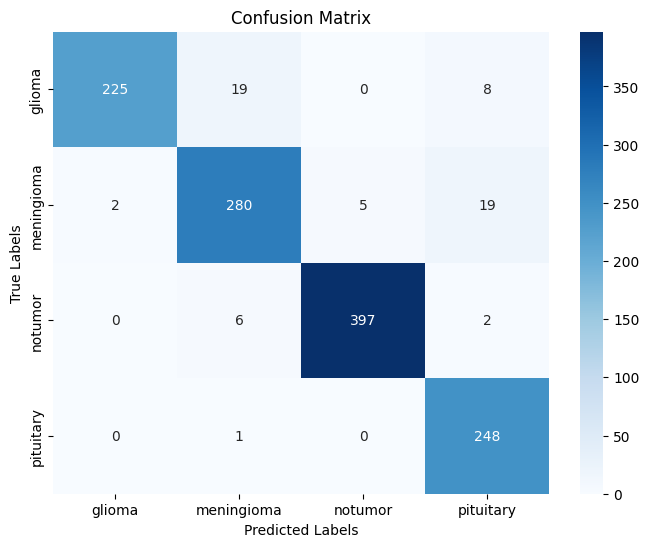

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()